In [16]:
import pandas as pd
import os, glob, sys
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

from matplotlib import dates

In [2]:
ticker = 'BTC'

In [3]:
os.path.abspath("")

'C:\\Users\\bgamb\\PycharmProjects\\IB'

In [4]:
path_to_folder = os.path.join(os.getcwd(),'Data')
os.chdir(path_to_folder)

In [5]:
path_to_file = glob.glob(os.path.join(ticker, '*'))[-1]
print(path_to_file)

BTC\24-06-11-1309.csv


In [48]:
def bollinger_bands(series: pd.Series, length: int = 20, *, num_stds: tuple[float, ...] = (2, 0, -2), prefix: str = '') -> pd.DataFrame:
    # Ref: https://stackoverflow.com/a/74283044/
    rolling = series.rolling(length)
    bband0 = rolling.mean()
    bband_std = rolling.std(ddof=0)
    return pd.DataFrame({f'{prefix}{num_std}': (bband0 + (bband_std * num_std)) for num_std in num_stds})

def get_delta_avg(series: pd.Series, period: int=20, prefix: str='delta_avg'):
    delta = series.pct_change(1)
    return pd.DataFrame({f'{prefix}_{period}': delta.rolling(period).mean()})
    
def aggregate_indicator(data, column, indicator, length = 20, num_stds = (2, 0, -2), prefix='BB_', signal=True):
    if indicator == 'bollinger':
        b_bands = bollinger_bands(data[column], length, num_stds=num_stds, prefix=prefix)
        data = data.join(b_bands, on=['DateTime']).iloc[length:]
        if signal:
            conditions = [data[column]>data[f'{prefix}{num_stds[0]}'], 
            data[column]<data[f'{prefix}{num_stds[2]}']]
            choices = ['Overvalued', 'Undervalued']     # -1.0 = undervalued, 1.0=overvalued, 0.0=marketprice
            data['Signal'] = np.select(conditions, choices, 'Market')
        else:
            pass
    if indicator == 'delta_avg':
        delta_avg = get_delta_avg(data[column], length, prefix=prefix)
        data = data.join(delta_avg, on=['DateTime']).iloc[length:]
    return data

def cat_to_dummies(data, column, dropkey: str=None):
    '''
    Get dummies from categorical column and drop it
    Use dropkey to drop a category
    '''
    # Using OneHotEncoder
    if dropkey is not None:
        drop = [dropkey]
    encoder = OneHotEncoder(drop=drop, sparse_output=False, handle_unknown='error')
    X_encoded = pd.DataFrame(encoder.fit_transform(data[[column]]), columns=encoder.get_feature_names_out())
    X_encoded['DateTime'] = data.index
    X_encoded.set_index(['DateTime'], inplace=True)
    return data.join(X_encoded, on=['DateTime']).drop([column], axis=1)

# Reset Dataframe

In [43]:
df = pd.read_csv(path_to_file, index_col='DateTime')
# I only need Close price for the analysis
df = df.drop(['Open', 'High', 'Low'], axis=1)
df.head()

,Close
DateTime,
2024-04-02 20:01:00,65720.00
2024-04-02 21:00:00,65708.50
2024-04-02 22:00:00,65829.25
2024-04-02 23:00:00,65463.25
2024-04-03 00:00:00,65406.00


# Get features and indicators

In [44]:
df = aggregate_indicator(df, column='Close', indicator='bollinger', length=10, num_stds=(1.5, 0, -1.5), prefix='Close_BB5_', signal=True)
df = aggregate_indicator(df, column='Close', indicator='delta_avg', length=10, prefix='delta_avg')
# data['SMA5'] = data['Close'].rolling(window=5).mean()
# data['SMA10'] = data['Close'].rolling(window=10).mean()
# data['SMA20'] = data['Close'].rolling(window=20).mean()
df['std_10'] = df['Close'].rolling(10).std()

In [45]:
data = df.iloc[10:]
data.head()

,Close,Close_BB5_1.5,Close_BB5_0,Close_BB5_-1.5,Signal,delta_avg_10,std_10
DateTime,,,,,,,
2024-04-04 02:00:00,65786.75,66254.888026,65996.750,65738.611974,Market,-0.000669,181.400914
2024-04-04 03:00:00,65644.75,66264.444188,65961.575,65658.705812,Undervalued,-0.000529,212.834771
2024-04-04 04:00:00,65494.75,66275.487221,65909.450,65543.412779,Undervalued,-0.000787,257.224740
2024-04-04 05:00:00,65602.25,66276.077254,65884.925,65493.772746,Market,-0.000368,274.873785
2024-04-04 06:00:00,65781.50,66277.245244,65889.425,65501.604756,Market,0.000074,272.532288


In [50]:
df = cat_to_dummies(data,'Signal', 'Market')
df

,Close,Close_BB5_1.5,Close_BB5_0,Close_BB5_-1.5,delta_avg_10,std_10,Signal_Overvalued,Signal_Undervalued
DateTime,,,,,,,,
2024-04-04 02:00:00,65786.75,66254.888026,65996.750,65738.611974,-0.000669,181.400914,0.0,0.0
2024-04-04 03:00:00,65644.75,66264.444188,65961.575,65658.705812,-0.000529,212.834771,0.0,1.0
2024-04-04 04:00:00,65494.75,66275.487221,65909.450,65543.412779,-0.000787,257.224740,0.0,1.0
2024-04-04 05:00:00,65602.25,66276.077254,65884.925,65493.772746,-0.000368,274.873785,0.0,0.0
2024-04-04 06:00:00,65781.50,66277.245244,65889.425,65501.604756,0.000074,272.532288,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-06-11 07:00:00,67542.00,69555.824459,68476.375,67396.925541,-0.002933,758.559758,0.0,0.0
2024-06-11 08:00:00,67496.25,69318.359043,68280.175,67241.990957,-0.002854,729.561379,0.0,0.0
2024-06-11 09:00:00,67062.50,69003.632409,68035.550,67067.467591,-0.003570,680.298972,0.0,1.0


In [52]:
df = df.drop(['Close_BB5_1.5', 'Close_BB5_0','Close_BB5_-1.5'], axis=1)
df

,Close,delta_avg_10,std_10,Signal_Overvalued,Signal_Undervalued
DateTime,,,,,
2024-04-04 02:00:00,65786.75,-0.000669,181.400914,0.0,0.0
2024-04-04 03:00:00,65644.75,-0.000529,212.834771,0.0,1.0
2024-04-04 04:00:00,65494.75,-0.000787,257.224740,0.0,1.0
2024-04-04 05:00:00,65602.25,-0.000368,274.873785,0.0,0.0
2024-04-04 06:00:00,65781.50,0.000074,272.532288,0.0,0.0
...,...,...,...,...,...
2024-06-11 07:00:00,67542.00,-0.002933,758.559758,0.0,0.0
2024-06-11 08:00:00,67496.25,-0.002854,729.561379,0.0,0.0
2024-06-11 09:00:00,67062.50,-0.003570,680.298972,0.0,1.0


In [73]:
columns = df.columns.to_list()
columns.remove('Close')

In [74]:
columns


['delta_avg_10', 'std_10', 'Signal_Overvalued', 'Signal_Undervalued']

In [258]:
# Convert DataFrame to matrix
# mat = data.drop(['Signal'], axis=1).values
mat = cluster_data.values
# Using sklearn
km = KMeans(n_clusters=5)
km.fit(mat)
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
categories = pd.DataFrame([data.index,labels]).T
categories.columns = ['DateTime', 'Category'] 
categories.set_index('DateTime', inplace=True)
categories['Category'] = pd.to_numeric(categories['Category'])
categories.head()

C:\Users\bgamb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bgamb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


,Category
DateTime,
2024-04-04 02:00:00,1
2024-04-04 03:00:00,1
2024-04-04 04:00:00,1
2024-04-04 05:00:00,1
2024-04-04 06:00:00,1


In [259]:
new_data = data.join(categories, on=['DateTime'])
new_data.head()

,Close,Close_BB5_1.5,Close_BB5_0,Close_BB5_-1.5,Signal,delta_avg_10,std_10,Category
DateTime,,,,,,,,
2024-04-04 02:00:00,65786.75,66254.888026,65996.750,65738.611974,Market,-0.000669,181.400914,1
2024-04-04 03:00:00,65644.75,66264.444188,65961.575,65658.705812,Undervalued,-0.000529,212.834771,1
2024-04-04 04:00:00,65494.75,66275.487221,65909.450,65543.412779,Undervalued,-0.000787,257.224740,1
2024-04-04 05:00:00,65602.25,66276.077254,65884.925,65493.772746,Market,-0.000368,274.873785,1
2024-04-04 06:00:00,65781.50,66277.245244,65889.425,65501.604756,Market,0.000074,272.532288,1


Using matplotlib backend: qtagg


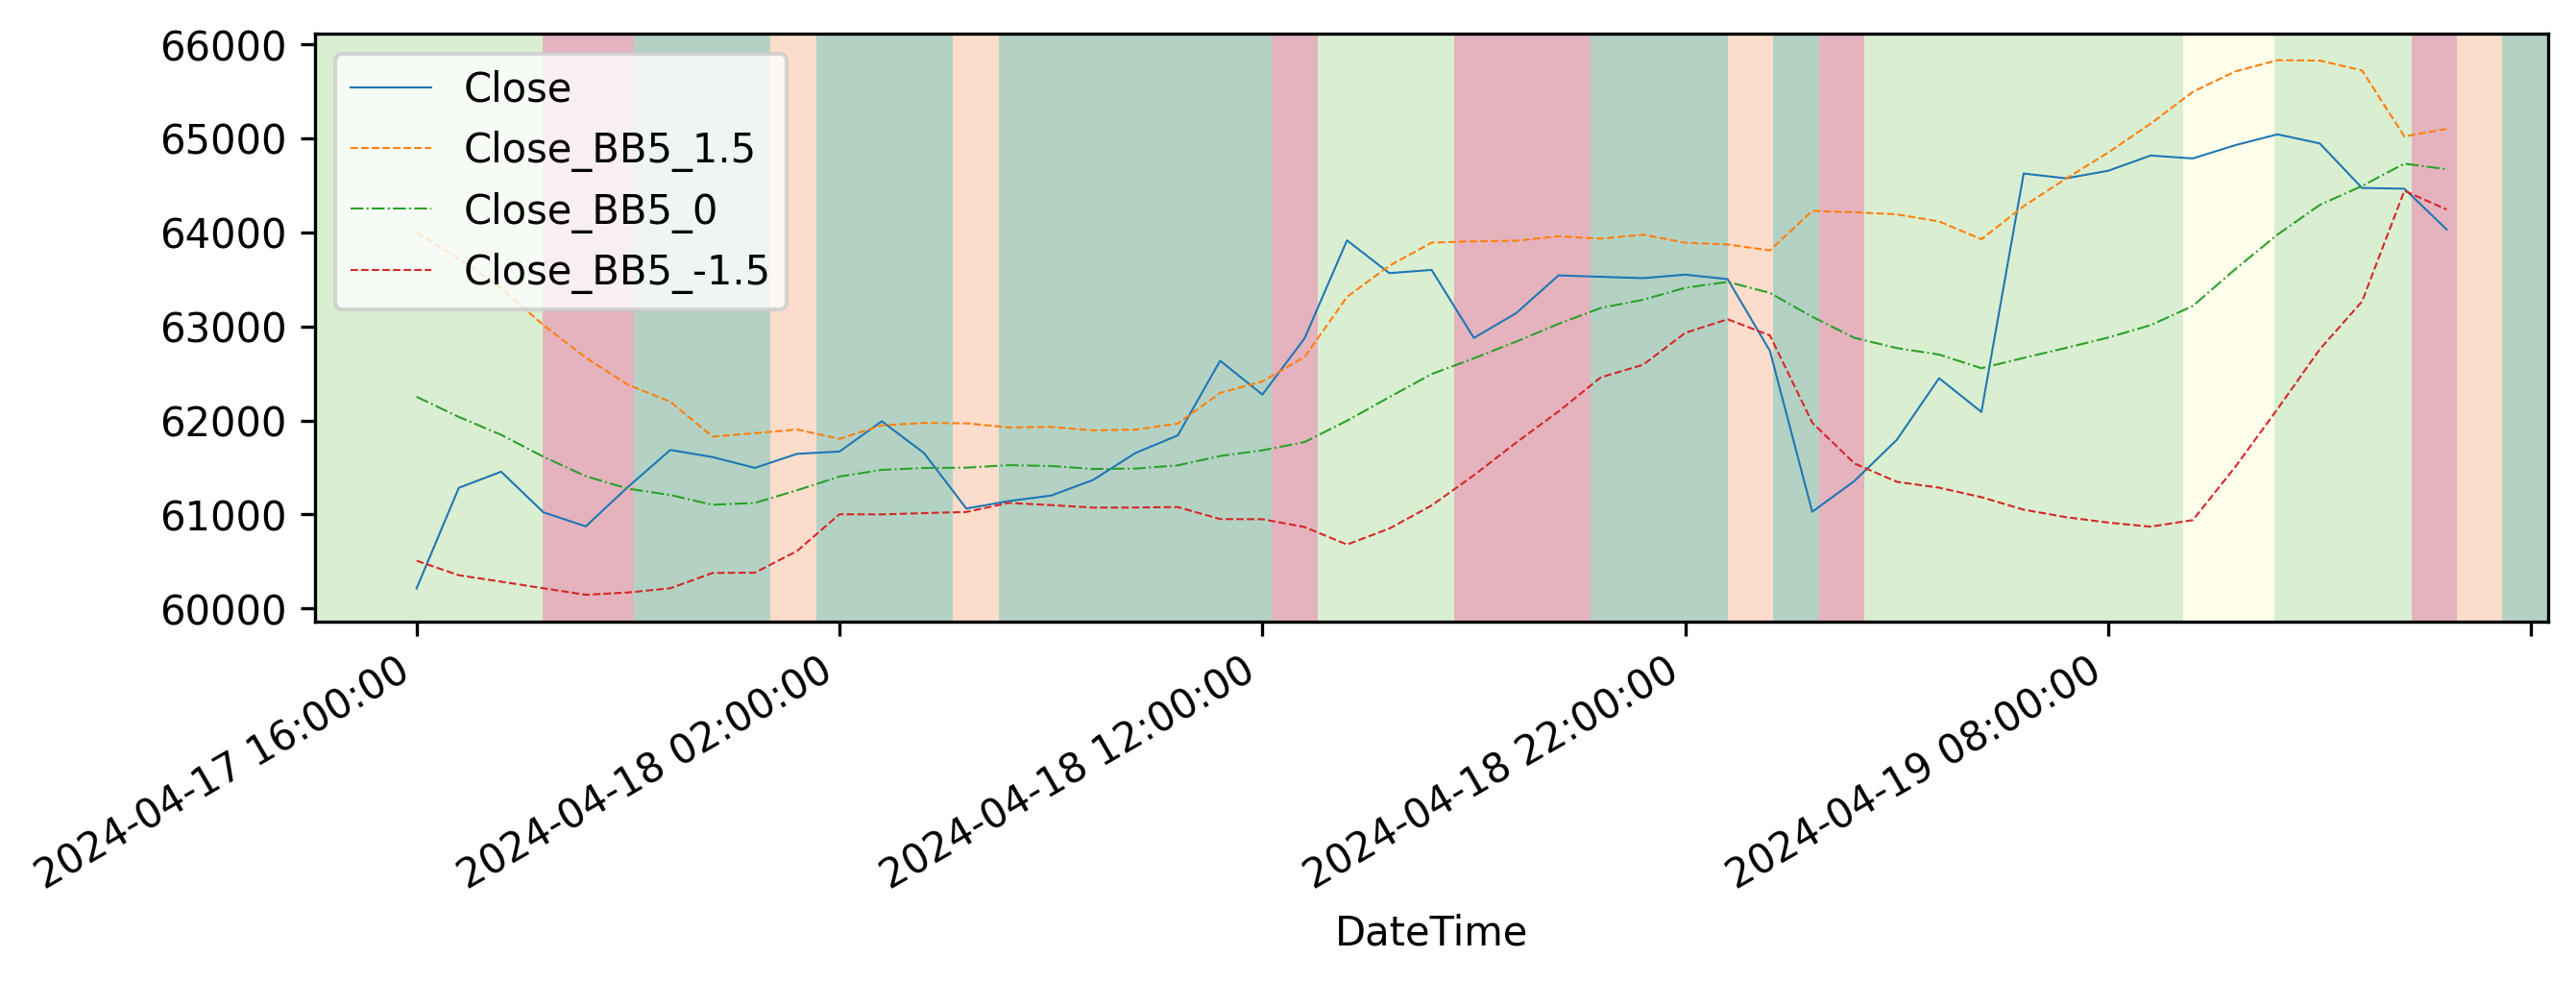

In [261]:
%matplotlib
%matplotlib inline
fig, ax = plt.subplots(dpi=300, figsize=(10,3))
plt_data = new_data['2024-04-17 16:00:00':'2024-04-19 16:00:00']
plt_data['Close'].plot(ax=ax, lw=0.5)
plt_data['Close_BB5_1.5'].plot(ax=ax, ls='--', lw=0.5)
plt_data['Close_BB5_0'].plot(ax=ax, ls='-.', lw=0.5)
plt_data['Close_BB5_-1.5'].plot(ax=ax, ls='--', lw=0.5)
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(), plt_data['Category'].values[np.newaxis], cmap='RdYlGn', alpha=0.3)
#myFmt = dates.DateFormatter('%m-%d %H')
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_major_locator(dates.HourLocator(interval=20))
## Rotate date labels automatically
fig.autofmt_xdate()
ax.legend()
plt.ion()
plt.show()

In [96]:
test_data = new_data.drop(['SMA5','SMA10','SMA20','Signal'], axis=1)

In [111]:
test_data.iloc[0]

Close             66232.000000
Close_BB5_1.5     66619.668474
Close_BB5_0       66209.800000
Close_BB5_-1.5    65799.931526
Category             21.000000
Name: 2024-04-03 16:00:00, dtype: float64

In [113]:
state = test_data.iloc[0]

In [118]:
state = np.reshape(state, [1, test_data.shape[1]])
state

array([[6.62320000e+04, 6.66196685e+04, 6.62098000e+04, 6.57999315e+04,
        2.10000000e+01]])